# ANES


[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_gap.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [3]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [5]:
def values(series):
    return series.value_counts(dropna=False).sort_index()

## Read the Data

I'm using data I previous cleaned in [this notebook](https://github.com/AllenDowney/GssExtract/blob/main/notebooks/01_make_pacs_extract.ipynb).

In [6]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

In [7]:
# download("https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_pacs_2022.hdf")

In [8]:
df = pd.read_stata('anes_timeseries_cdf_stata_20220916.dta', convert_categoricals=False)
df.shape

(68224, 1030)

In [9]:
column_dict = {'VCF0004': 'year',
               'VCF0803': 'polviews',
               'VCF0301': 'partyid',
               'VCF0302': 'partyid3',
               'VCF0104': 'sex',
               'VCF0101': 'age',
               'VCF0009z': 'wtsamp'}

df.rename(columns=column_dict, inplace=True)

In [10]:
recode_polviews = {
    1: "Liberal",
    2: "Moderate",
    3: "Conservative",
}
df["polviews3"] = df["VCF0804"].replace(recode_polviews)
df["polviews3"].value_counts()

/tmp/ipykernel_206186/1324274489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["polviews3"] = df["VCF0804"].replace(recode_polviews)


polviews3
Conservative    15631
Moderate        12532
Liberal         10984
9.0              9568
0.0              4193
Name: count, dtype: int64

In [11]:
df['wtsamp'].describe()

count    68224.000000
mean         1.039790
std          0.564906
min          0.021200
25%          0.896200
50%          1.000000
75%          1.000000
max          6.932929
Name: wtsamp, dtype: float64

In [12]:
values(df['year'])

year
1948.0     662
1952.0    1899
1954.0    1139
1956.0    1762
1958.0    1450
1960.0    1181
1962.0    1297
1964.0    1571
1966.0    1291
1968.0    1557
1970.0    1507
1972.0    2705
1974.0    1575
1976.0    2248
1978.0    2304
1980.0    1614
1982.0    1418
1984.0    2257
1986.0    2176
1988.0    2040
1990.0    1980
1992.0    2485
1994.0    1795
1996.0    1714
1998.0    1281
2000.0    1807
2002.0    1511
2004.0    1212
2008.0    2322
2012.0    5914
2016.0    4270
2020.0    8280
Name: count, dtype: int64

The primary variable we'll use is [polviews](https://subsetdataexplorer.norc.org/variables/178/vshow), which asks

> We hear a lot of talk these days about liberals and conservatives. I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

In [13]:
values(df['sex'])

sex
0.0      211
1.0    30612
2.0    37390
3.0       11
Name: count, dtype: int64

In [14]:
values(df['age'])

age
0.0      887
17.0      21
18.0     498
19.0     605
20.0     690
        ... 
96.0       3
97.0       2
98.0       2
99.0       4
NaN     1801
Name: count, Length: 85, dtype: int64

In [15]:
df['age'].replace(0, np.nan, inplace=True)

In [16]:
values(df['polviews'])

polviews
0.0     2400
1.0     1229
2.0     4821
3.0     4934
4.0    12532
5.0     6567
6.0     7523
7.0     1541
9.0    11361
NaN    15316
Name: count, dtype: int64

In [17]:
values(df['VCF0804'])

VCF0804
0.0     4193
1.0    10984
2.0    12532
3.0    15631
9.0     9568
NaN    15316
Name: count, dtype: int64

In [18]:
values(df['partyid3'])

partyid3
1.0    14125
2.0    15856
3.0     2937
4.0      733
5.0    20437
8.0      133
9.0      244
NaN    13759
Name: count, dtype: int64

In [19]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby("year")
    samples = [resample_rows_weighted(group, column) for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [20]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, _ = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [21]:
def plot_percentiles(series_seq, ps=None, label=None, **options):
    """Plot the low, median, and high percentiles.

    series_seq: sequence of Series
    ps: percentiles to use for low, medium and high
    label: string label for the median line
    options: options passed plt.plot and plt.fill_between
    """
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    assert len(ps) == 3

    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

In [22]:
def resample_diffs_smooth(df, query, iters=101):
    diffs = []
    for i in range(iters):
        sample = resample_by_year(df, "wtsamp").query(query)
        diff = make_diff(sample)
        smooth = make_lowess(diff)
        diffs.append(smooth)
    return diffs

In [23]:
recent = df.query('year >= 1972 and year != 1990')

In [24]:
df_con = recent.query('polviews3 == "Conservative"')
df_lib = recent.query('polviews3 == "Liberal"')

In [25]:
def compute_diff(col):
    con = df_con[col].dropna().value_counts()
    if len(con) == 0:
        return np.nan
    lib = df_lib[col].dropna().value_counts()
    value = con.idxmax()
    p_con = con[value] / con.sum()
    p_lib = lib.get(value, np.nan) / lib.sum()
    return abs(p_con - p_lib)

In [26]:
res = []
for col in recent.columns:
    diff = compute_diff(col)
    res.append((col, diff))

In [27]:
candidates = pd.DataFrame(res).dropna().sort_values(by=1, ascending=False).head(200).tail(101)
candidates

,0,1
896,VCF9084,0.227218
256,VCF0387b,0.224657
622,VCF0877,0.224601
821,VCF9013,0.223856
610,VCF0866,0.222141
...,...,...
176,VCF0338,0.121605
579,VCF0829,0.120603
127,VCF0214,0.120292
765,VCF1020,0.119937


In [28]:
string_to_empty_dict = {key: '' for key in candidates[0]}

In [29]:
candidate_dict = {
 'VCF0849': 'lib or con',
 'VCF0303': 'partyid',
 'VCF0713': 'voting intent',
 'VCF9204': 'which party',
 'VCF0704': 'vote',
 'VCF0705': 'vote',
 'VCF0704a': 'vote',
 'VCF0706': 'vote',
 'VCF9205': 'party',
 'VCF9027': '',
 'VCF0487': '',
 'VCF9209': '',
 'VCF0475': '',
 'VCF9212': '',
 'VCF0372': '',
 'VCF0360': '',
 'partyid3': '',
 'VCF9210': '',
 'VCF0734': '',
 'VCF9131': 'LESS GOVERNMENT BETTER OR GOVERNMENT DO MORE',
 'VCF0709': '',
 'VCF0386': '',
 'VCF0373': '',
 'VCF0894': 'FEDERAL SPENDING- WELFARE PROGRAMS',
 'VCF0481': '',
 'VCF0361': '',
 'VCF0700': '',
 'VCF0374': '',
 'VCF0493': '',
 'VCF0707': '',
 'VCF0736': '',
 'VCF9133': 'GOVT TOO INVOLVED IN THINGS OR PROBLEMS REQUIRE',
 'VCF0876a': 'LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION',
 'VCF9238': 'SHOULD THE GOVERNMENT MAKE IT MORE DIFFICULT OR EASIER TO BUY A GUN, OR SHOULD THE RULES STAY THE SAME AS THEY ARE NOW',
 'VCF0385b': '',
 'VCF0401': '',
 'VCF0370': '',
 
 'VCF0371': '',
 'VCF0853': 'SHOULD BE MORE EMPHASIS ON TRADITIONAL VALUES',
 'VCF0878': 'SHOULD GAYS/LESBIANS BE ABLE TO ADOPT CHILDREN',
 'VCF9228': 'MUCH OR SOMEWHAT LARGER/SMALLER GAP IN INCOMES BETWEEN RICH AND POOR IN THE U.S. THAN 20 YEARS AGO',
 'VCF0867a': 'AFFIRMATIVE ACTION IN HIRING/PROMOTION',
 'VCF0405': '',
 'VCF0359': '',
 'VCF9085': '',
 'VCF9132': 'GOVT HANDLE ECONOMY OR FREE MARKET CAN HANDLE',
 'VCF0877a': 'POSITION ON GAYS IN THE MILITARY',
 'VCF9237': 'STRENGTH FAVOR/OPPOSE THE DEATH PENALTY FOR PERSONS CONVICTED OF MURDER',
 'VCF9236': 'FAVOR OR OPPOSE THE DEATH PENALTY FOR PERSONS CONVICTED OF MURDER',
 'VCF9207': '',
 'VCF9275': 'IN AMERICAN POLITICS, DO BLACKS HAVE TOO MUCH, ABOUT THE RIGHT AMOUNT OF, OR TOO LITTLE INFLUENCE',
 'partyid': '',
 'VCF0890': 'FEDERAL SPENDING- PUBLIC SCHOOLS',
 'VCF9219': '',
 'VCF0358': '',
 'VCF1043b': '',
 'VCF9086': '',
 'VCF9213': '',
 'VCF0369': '',
 'VCF9211': '',
 'VCF9088': '',
 'VCF0833': 'FAVOR OR OPPOSE EQUAL RIGHTS AMENDMENT',
 'VCF0406': '',
 'VCF0601': 'APPROVE PARTICIPATION IN PROTESTS',
 'VCF0851': 'NEWER LIFESTYLES CONTRIBUTE TO SOCIETY BREAKDOWN',
 'VCF0852': 'SHOULD ADJUST VIEW OF MORAL BEHAVIOR TO CHANGES',
 'VCF0867': 'AFFIRMATIVE ACTION IN HIRING/PROMOTION',
 'VCF0893': 'FEDERAL SPENDING- THE HOMELESS',
 'VCF0846': 'IS RELIGION IMPORTANT TO RESPONDENT',
 'VCF9241': '',
 'VCF1004': '',
 'VCF0738': '',
 'VCF0392': '',
 'VCF9215': '',
 'VCF0879a': 'INCREASE OR DECREASE NUMBER OF IMMIGRANTS TO U.S. 4-CATEGORY',
 'VCF0889': 'FEDERAL SPENDING- AIDS RESEARCH/FIGHT AIDS',
 'VCF9028': '',
 'VCF0876': 'LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION',
 'VCF9216': '',
 'VCF9249': 'WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: INDEPENDENCE OR RESPECT FOR ELDERS',
 'VCF0828': 'SHOULD GOVERNMENT CUT MILITARY SPENDING',
 'VCF0838': 'WHEN SHOULD ABORTION BE ALLOWED',
 'VCF9247': 'WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: OBEDIENCE OR SELF-RELIANCE',
 'VCF1042b': '',
 'VCF9227': 'DOES R THINK THE DIFFERENCE IN INCOMES BETWEEN RICH AND POOR IN THE U.S. IS LARGER, SMALLER, OR ABOUT THE SAME AS 20 YEARS AGO',
 'VCF9040': 'BLACKS SHOULD NOT HAVE SPECIAL FAVORS TO SUCCEED',
 'VCF0424': '',
 'VCF9246': 'WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: CURIOSITY OR GOOD MANNERS',
 'VCF0318': '',
 'VCF0826': 'DID U.S. DO RIGHT THING GETTING INVOLVED IN WAR (DIFFERENT WARS)',
 'VCF9047': 'FEDERAL SPENDING- IMPROVE AND PROTECT THE ENVIRONMENT',
 'VCF9046': 'FEDERAL SPENDING- FOOD STAMPS',
 'VCF0391b': '',
 'VCF0603': 'APPROVE DEMONSTRATIONS',
 'VCF0602': 'APPROVE CIVIL DISOBEDIENCE',
 'VCF0314': '',
 'VCF0808': 'GUARANTEED JOBS AND INCOME',
 'VCF9214': '',
 'VCF9084': '',
 'VCF0380': '',
 'VCF9008': '',
 'VCF0877': 'FAVOR OR OPPOSE GAYS IN THE MILITARY',
 'VCF0834': 'WOMEN EQUAL ROLE SCALE',
 'VCF0387b': '',
 'VCF0866': '',
 'VCF9201': '',
 'VCF0817': 'SCHOOL BUSING SCALE',
 'VCF9013': 'SOCIETY SHOULD ENSURE EQUAL OPPORTUNITY TO SUCCEED',
 'VCF9014': 'WE HAVE GONE TOO FAR PUSHING EQUAL RIGHTS',
 'VCF0738a': '',
 'VCF0402': '',
 'VCF9232': 'FAVOR OR OPPOSE THE U.S. GOVERNMENT TORTURING PEOPLE WHO ARE SUSPECTED OF BEING TERRORISTS, TO TRY TO GET INFORMATION',
 'VCF0128': '',
 'VCF0425': '',
 'VCF9037': 'GOVERNMENT SHOULD ENSURE FAIR JOBS FOR BLACKS',
 'VCF0363': '',
 'VCF9042': 'BLACKS GOTTEN LESS THAN THEY DESERVE OVER THE PAST FEW YEARS',
 'VCF0365': '',
 'VCF9077': 'PRESIDENT ON GOVERNMENT HEALTH INSURANCE SCALE',
 'VCF0215': 'THERMOMETER',
 'VCF0471': '',
 'VCF0235': '',
 'VCF9051': 'SCHOOL PRAYER ALLOWED 2-CATEGORY',
 'VCF0847': 'HOW MUCH GUIDANCE FROM RELIGION',
 'VCF9017': 'SHOULD WORRY LESS ABOUT HOW EQUAL PEOPLE ARE',
 'VCF1037b': '',
 'VCF0806': 'GOVERNMENT HEALTH INSURANCE SCALE',
 'VCF0426': '',
 'VCF0357': '',
 'VCF0130': '',
 'VCF0711': '',
 'VCF0886': 'FEDERAL SPENDING- POOR/POOR PEOPLE',
 'VCF9280': '',
 'VCF0442': '',
 'VCF9221': '',
 'VCF0387a': '',
 'VCF0815': 'SEGREGATION OR DESEGREGATION',
 'VCF0837': 'WHEN SHOULD ABORTION BE ALLOWED',
 'VCF0809': 'GUARANTEED JOBS AND INCOME SCALE',
 'VCF0147': '',
 'VCF0212': '',
 'VCF1030b': '',
 'VCF0447': '',
 'VCF9235': '',
 'VCF9202': '',
 'VCF9041': 'BLACKS MUST TRY HARDER TO SUCCEED',
 'VCF9014': 'WE HAVE GONE TOO FAR PUSHING EQUAL RIGHTS',
 'VCF0381b': '',
 'VCF0830': 'AID TO BLACKS SCALE',
 'VCF0443': '',
 'VCF0440': '',
 'VCF0816': 'SHOULD GOVERNMENT ENSURE SCHOOL INTEGRATION',
 'VCF0319': '',
 'VCF9087': '',
 'VCF0146': '',
 'VCF0218': '',
 'VCF0356': '',
 'VCF1038': '',
 'VCF0860': '',
 'VCF0224': '',
 'VCF0355': '',
 'VCF0433': '',
 'VCF0845': '',
 'VCF9208': '',
 'VCF0985': '',
 'VCF1032': '',
 'VCF0888': 'FEDERAL SPENDING- DEALING WITH CRIME',
 'VCF0427': '',
 'VCF9240': '',
 'VCF0315': '',
 'VCF0381a': '',
 'VCF9015': 'BIG PROBLEM THAT NOT EVERYONE HAS EQUAL CHANCE',
 'VCF0892': 'FEDERAL SPENDING- FOREIGN AID',
 'VCF9016': 'NOT BIG PROBLEM IF SOME HAVE MORE CHANCE IN LIFE',
 'VCF0153b': '',
 'VCF0130a': '',
 'VCF9220': '',
 'VCF0606': 'HOW MUCH DOES THE FEDERAL GOVERNMENT WASTE TAX MONEY',
 'VCF0508': '',
 'VCF0384b': '',
 'VCF0748': '',
 'VCF0339': '',
 'VCF9094': '',
 'VCF9078': '',
 'VCF0842': 'ENVIRONMENTAL REGULATION SCALE',
 'VCF9231': 'FAVOR OR OPPOSE PLACING LIMITS ON IMPORTS TO PROTECT AMERICAN JOBS',
 'VCF0891': 'FEDERAL SPENDING- FIN AID FOR COLLEGE STUDENTS',
 'VCF0233': '',
 'VCF0153a': '',
 'VCF0368': '',
 'VCF9081': '',
 'VCF9048': 'FEDERAL SPENDING- SPACE/SCIENCE/TECHNOLOGY',
 'VCF9092': '',
 'VCF9039': 'CONDITIONS MAKE IT DIFFICULT FOR BLACKS TO SUCCEED',
 'VCF9248': 'WHICH IS MORE IMPORTANT FOR A CHILD TO BE: CONSIDERATE OR WELL-BEHAVED',
 'VCF9226': '',
 'VCF0396b': '',
 'VCF1020': '',
 'VCF0338': '',
 'VCF0829': 'IS THE GOVERNMENT IN WASHINGTON TOO STRONG',
 'VCF0214': ''}

In [30]:
{
    'VCF9230': 'SHOULD THE FEDERAL GOVERNMENT ENCOURAGE OR DISCOURAGE AMERICAN COMPANIES TO REPLACE U.S. WORKERS WITH FOREIGN WORKERS, OR STAY OUT',
    '': '',
    '': '',
    '': '',
    '': '',
    '': '',
}

{'VCF9230': 'SHOULD THE FEDERAL GOVERNMENT ENCOURAGE OR DISCOURAGE AMERICAN COMPANIES TO REPLACE U.S. WORKERS WITH FOREIGN WORKERS, OR STAY OUT',
 '': ''}

In [31]:
issue_dict = {
    'VCF9249': 'CHILDREN: INDEPENDENCE OR\nRESPECT FOR ELDERS',
    'VCF9246': 'CHILDREN: CURIOSITY OR\nGOOD MANNERS',
    'VCF9247': 'CHILDREN: SELF-RELIANCE OR\nOBEDIENCE',
    'VCF9248': 'CHILDREN: CONSIDERATE OR\nWELL-BEHAVED',
    #'VCF0601': 'APPROVE PARTICIPATION\nIN PROTESTS',
    #'VCF0602': 'APPROVE CIVIL DISOBEDIENCE',
    #'VCF0603': 'APPROVE DEMONSTRATIONS',
    #'VCF0604': 'TRUST THE FEDERAL GOVERNMENT\nTO DO WHAT IS RIGHT',
    #'VCF0605': 'FEDERAL GOVERNMENT RUN BY FEW INTERESTS\nOR FOR THE BENEFIT OF ALL',
    #'VCF0606': 'HOW MUCH DOES THE FEDERAL\nGOVERNMENT WASTE TAX MONEY',
    #'VCF0607': 'HOW MANY GOVERNMENT OFFICIALS\nARE SMART',
    #'VCF0608': 'HOW MANY GOVERNMENT OFFICIALS\nARE CROOKED',
    #'VCF0609': 'GOVERNMENT OFFICIALS CARE\nWHAT PEOPLE LIKE YOU THINK',
    'VCF9133': 'GOVT TOO INVOLVED IN THINGS',
    'VCF9131': 'LESS GOVERNMENT BETTER OR\nGOVERNMENT DO MORE',
    'VCF9132': 'GOVT HANDLE ECONOMY OR\nFREE MARKET CAN HANDLE',
    #'VCF9134': 'MORE IMPORTANT TO BE\nCOOPERATIVE OR SELF-RELIANT'
    'VCF0853': 'SHOULD BE MORE EMPHASIS\nON TRADITIONAL VALUES',
    'VCF0851': 'NEWER LIFESTYLES CONTRIBUTE\nTO SOCIETY BREAKDOWN',
    'VCF0852': 'SHOULD ADJUST VIEW OF\nMORAL BEHAVIOR TO CHANGES',
    'VCF0854': 'TOLERANCE OF DIFFERENT\nMORAL STANDARDS',
    'VCF9013': 'SOCIETY SHOULD ENSURE EQUAL\nOPPORTUNITY TO SUCCEED',
    'VCF9014': 'WE HAVE GONE TOO FAR\nPUSHING EQUAL RIGHTS',
    'VCF9015': 'BIG PROBLEM THAT NOT\nEVERYONE HAS EQUAL CHANCE',
    'VCF9016': 'NOT BIG PROBLEM IF SOME\nHAVE MORE CHANCE IN LIFE'
}

In [32]:
issue_names = [name.capitalize() for name in issue_dict.values()]

In [33]:
conservative_values = {
    "VCF9249": [3],
    "VCF9246": [3],
    "VCF9247": [1],
    "VCF9248": [3],
    'VCF0601': [1],
    'VCF0602': [1],
    'VCF0603': [1],
    'VCF0604': [1],
    'VCF0605': [1],
    'VCF0606': [1],
    'VCF0607': [1],
    'VCF0608': [1],
    'VCF0609': [1],
    'VCF9131': [1],
    'VCF9132': [2],
    'VCF9133': [1],
    'VCF9134': [1],
    'VCF0851': [1, 2],
    'VCF0852': [4, 5],
    'VCF0853': [1, 2],
    'VCF0854': [4, 5],
    'VCF9013': [3, 4, 5],
    'VCF9014': [1, 2],
    'VCF9015': [3, 4, 5],
    'VCF9016': [1, 2],
}

In [34]:
questions = pd.DataFrame(dtype=float)

for varname in issue_dict:
    questions[varname] = recent[varname].isin(conservative_values[varname]).astype(float)
    null = recent[varname].isna()
    questions.loc[null, varname] = np.nan

In [35]:
def add_column(df, column):
    return pd.concat([df, column], axis=1)

In [36]:
questions_year = add_column(questions, recent['year'])
over_time = questions_year.groupby("year").mean() * 100
over_time

,VCF9249,VCF9246,VCF9247,VCF9248,VCF9133,VCF9131,VCF9132,VCF0853,VCF0851,VCF0852,VCF0854,VCF9013,VCF9014,VCF9015,VCF9016
year,,,,,,,,,,,,,,,
1972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.481613,43.907842,50.553833,34.692069
1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.238971,67.325368,44.301471,24.356618,10.248162,46.553309,46.415441,31.479779
1988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.441176,62.450980,34.950980,20.343137,9.117647,38.088235,40.833333,30.833333


In [37]:
from scipy.stats import linregress

res = []
for column in over_time.columns:
    desc = issue_dict[column].replace('\n', ' ').capitalize()
    series = over_time[column].dropna()
    result = linregress(series.index, series.values)
    res.append((column, result.slope, desc))
    
pd.DataFrame(res, columns=['name', 'slope', 'desc']).sort_values(by='slope')

,name,slope,desc
7,VCF0853,-0.815817,Should be more emphasis on traditional values
8,VCF0851,-0.647175,Newer lifestyles contribute to society breakdown
12,VCF9014,-0.519427,We have gone too far pushing equal rights
14,VCF9016,-0.444187,Not big problem if some have more chance in life
9,VCF0852,-0.262650,Should adjust view of moral behavior to changes
10,VCF0854,-0.239277,Tolerance of different moral standards
2,VCF9247,-0.169059,Children: self-reliance or obedience
13,VCF9015,-0.051252,Big problem that not everyone has equal chance
3,VCF9248,0.092716,Children: considerate or well-behaved
0,VCF9249,0.118042,Children: independence or respect for elders


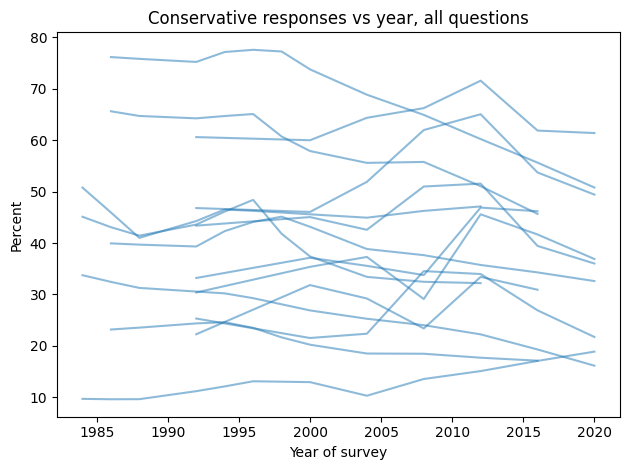

In [38]:
for column in over_time.columns:
    plot_series_lowess(over_time[column], plot_series=False, 
                       color='C0', alpha=0.5, label='')

decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Conservative responses vs year, all questions",
)

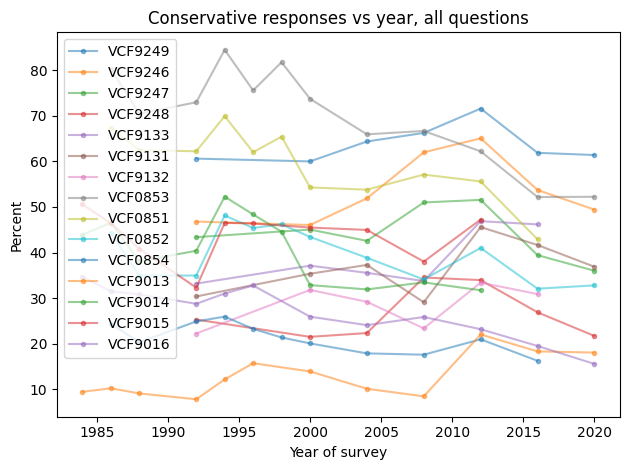

In [39]:
for column in over_time.columns:
    over_time[column].dropna().plot(style='.-', alpha=0.5)

decorate(
    xlabel="Year of survey",
    ylabel="Percent",
    title="Conservative responses vs year, all questions",
)

In [40]:
polview_names = ["Conservative", "Moderate", "Liberal"]

muted = sns.color_palette("muted", 5)
polview_color_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
marker_map = dict(zip(polview_names, ["s", "^", "o"]))
line_map = dict(zip(polview_names, [":", "-.", "--"]))

In [41]:
questions_polviews = pd.concat([questions, recent["polviews3"]], axis=1)
table = questions_polviews.groupby("polviews3").mean().transpose() * 100

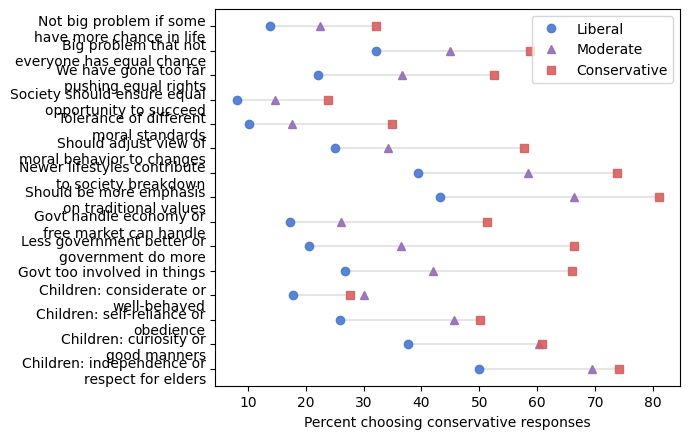

In [42]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in reversed(polview_color_map.items()):
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")

In [43]:
from scipy.special import logit

ds = -logit(questions.mean().values)
ds

array([-0.58204013, -0.17557325,  0.28149422,  1.0043515 ,  0.34748586,
        0.47958255,  0.86907422, -0.59689497, -0.30013037,  0.4981529 ,
        1.33507588,  1.72980877,  0.44616412,  0.23717334,  1.13991653])

In [44]:
from scipy.special import expit

es = np.linspace(-6, 6, 21)
E, D = np.meshgrid(es, ds)
P = expit(E - D)
Q = 1 - P
ns = P.sum(axis=0)

In [45]:
from scipy.stats import norm
from empiricaldist import Pmf

ps = norm.pdf(es, 0, 4)
prior = Pmf(ps, es)
prior.normalize();

In [46]:
n, m = questions.shape
size = n, m, len(es)
res = np.empty(size)

In [47]:
a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

In [48]:
product = res.prod(axis=1) * prior.values
posterior = product / product.sum(axis=1)[:, None]
con = (posterior * ns).sum(axis=1)
con.shape

(50928,)

In [49]:
answered = questions.notna().sum(axis=1)
(answered >= 3).mean()

0.7373743323908263

In [50]:
recent["conservatism"] = pd.Series(con, recent.index)
recent.loc[answered < 3, "conservatism"] = np.nan
recent["conservatism"].describe()

/tmp/ipykernel_206186/3702985926.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  recent["conservatism"] = pd.Series(con, recent.index)
/tmp/ipykernel_206186/3702985926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["conservatism"] = pd.Series(con, recent.index)


count    37553.000000
mean         6.091310
std          3.512552
min          0.406235
25%          3.329098
50%          6.001665
75%          8.551412
max         14.492074
Name: conservatism, dtype: float64

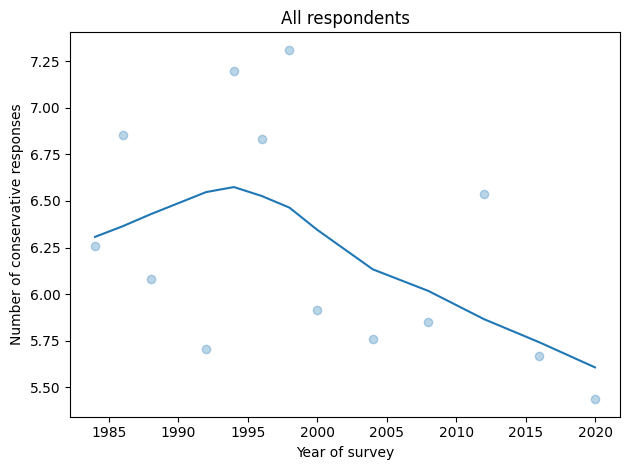

In [51]:
series = recent.groupby("year")["conservatism"].mean()

plot_series_lowess(series, frac=0.7, color="C0", label="")
decorate(xlabel="Year of survey", 
         ylabel="Number of conservative responses",
         title='All respondents')

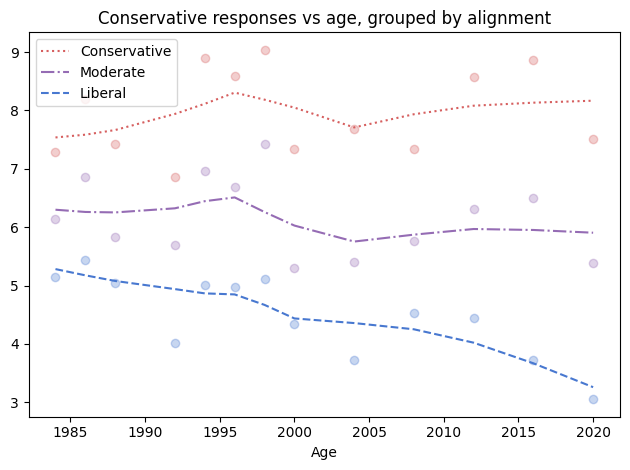

In [52]:
table = recent.pivot_table(index="year", columns="polviews3", values="conservatism")

columns = ["Conservative", "Moderate", "Liberal"]
options = dict(frac=0.6, plot_series=True)

for column in columns:
    plot_series_lowess(
        table[column], ls=line_map[column], color=polview_color_map[column], **options
    )

# plot_series_lowess(series, ls="-", color="gray", alpha=0.5, label="overall")

decorate(
    xlabel="Age",
    title="Conservative responses vs age, grouped by alignment",
)
plt.tight_layout()